# CSCE 633 Machine Learning project proposal – Classification of bacterial genes by high-throughput phenotype data

## Data preparation

In [2]:
#!rm -r CSCE633_Machine_Learning
!git clone https://github.com/peterwu19881230/CSCE633_Machine_Learning
!pip install -q xlrd

Cloning into 'CSCE633_Machine_Learning'...
remote: Enumerating objects: 18, done.
remote: Counting objects: 100% (18/18), done.
remote: Compressing objects: 100% (18/18), done.
remote: Total 228 (delta 9), reused 2 (delta 0), pack-reused 210
Receiving objects: 100% (228/228), 162.96 MiB | 24.16 MiB/s, done.
Resolving deltas: 100% (67/67), done.
Checking out files: 100% (35/35), done.


In [3]:
import pandas as pd
import numpy as np
df=pd.read_csv('CSCE633_Machine_Learning/final_project/Nich_Price_quantitative.csv',header=None,index_col=0)

#What if I normalize the scores by genes (rows)? -> Tried. Accuracy, Precision didn't improve
#What if I normalize the scores by conditions?

#normalize the features
from sklearn import preprocessing
min_max_scaler = preprocessing.MinMaxScaler()
df = pd.DataFrame(min_max_scaler.fit_transform(df))


annotation_dummies=pd.read_csv('CSCE633_Machine_Learning/final_project/annot_dummies.csv',header=0,index_col=None, engine='python') #engine='c' (default) gives error
twenty_cluster_labels=pd.read_csv('CSCE633_Machine_Learning/final_project/annot_20_clusters_hclust_hamming.csv',header=None)
twenty_cluster_labels_corrected=twenty_cluster_labels.iloc[list(df.index.values-1)]

print(df.shape)
print(df.index)
#print(df.iloc[0:5,0:5])
print(df.head(5))
print("\n\n")
print(annotation_dummies.shape)
print(annotation_dummies.head(5))
print("\n\n")
print(twenty_cluster_labels_corrected.iloc[:,0].value_counts()) #why doesn't this contain class 20 -> probably because class 20 is not in the shared strains of Nichols' and Price's

(3525, 486)
RangeIndex(start=0, stop=3525, step=1)
        0         1         2    ...       483       484       485
0  0.820731  0.900354  0.866723  ...  0.519117  0.517772  0.536818
1  0.898970  0.898060  0.882701  ...  0.523339  0.516099  0.545103
2  0.883081  0.844615  0.861799  ...  0.541189  0.497719  0.554506
3  0.852245  0.900495  0.879212  ...  0.548596  0.435791  0.548139
4  0.890362  0.879126  0.821682  ...  0.504847  0.496176  0.499616

[5 rows x 486 columns]



(3979, 5031)
   HOMOSERSYN-PWY  ...  eco_M00192  Putative thiamine transport system
0               0  ...                                               0
1               0  ...                                               0
2               0  ...                                               0
3               0  ...                                               0
4               0  ...                                               0

[5 rows x 5031 columns]



1     3115
4      161
2      104
6       44
12      1

In [4]:
#remove class 1 (Class 1 seems to be profiles with little annotation. And there are too many of it)
not_class_1_index=np.where(twenty_cluster_labels_corrected.iloc[:,0].values == 1, False, True)
X=df[not_class_1_index]
y=twenty_cluster_labels_corrected[not_class_1_index]
print(X.shape)
print(y.iloc[:,0].value_counts())

# try using class 4, 2, 6, 12, 5, 3, 13 (classes that seem to have sufficient samples to build the models)
keep=keep=np.array(y.isin([4, 2, 6, 12, 5, 3, 13])).ravel()
X=X[keep]
y=y[keep]
print(X.shape)
print(y.iloc[:,0].value_counts())
y=np.array(y).ravel()

#To ensure y labels are interpreted correctly, I converted them to 0~5
#tf.keras.utils.to_categorical has this problem: if y=[6,9,10], there will be dummy variables 0~10, not just 0~2 (https://stackoverflow.com/questions/41494625/issues-using-keras-np-utils-to-categorical/43314437)
y=[str(class_) for class_ in y] #convert the label to string 
map_={'4':0,'2':1,'6':2,'12':3,'5':4,'3':5,'13':6}
y=[map_[class_] for class_ in y]

(410, 486)
4     161
2     104
6      44
12     19
3      16
11     16
5      14
13      9
16      6
8       4
10      4
9       4
7       2
14      2
15      2
18      1
17      1
19      1
Name: 0, dtype: int64
(367, 486)
4     161
2     104
6      44
12     19
3      16
5      14
13      9
Name: 0, dtype: int64


## Analysis

### Supervised Learning

In [0]:
#This part of code gets error so I am temporarily ignoring it:
#error: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.

#grid_search = GridSearchCV(model, param_grid={},cv=cv,scoring='precision_weighted') # Use sorted(sklearn.metrics.SCORERS.keys()) to get valid options.
#grid_search.fit(X, y) 
#print('Precision= ',grid_search.best_score_)

In [5]:
# logtistic regression 
#ref for one-vs-rest logtistic regression: https://chrisalbon.com/machine_learning/logistic_regression/one-vs-rest_logistic_regression/
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import make_scorer

cv=3


model=LogisticRegression(solver='newton-cg',multi_class='ovr',penalty='l2')

grid_search = GridSearchCV(model, param_grid={},cv=cv,scoring='accuracy') 
grid_search.fit(X, y) 
print('Accuracy= ',grid_search.best_score_)

Accuracy=  0.34332425068119893


In [6]:
#SVM
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV



param_grid = [{'kernel': ['rbf'], 'gamma': [1e-3, 1e-4],
                     'C': [1, 10, 100, 1000]},
                    {'kernel': ['linear'], 'C': [1, 10, 100, 1000]}]
                    
model=SVC()

grid_search = GridSearchCV(model, param_grid=param_grid,cv=cv,scoring='accuracy') 
grid_search.fit(X, y) 
print('Accuracy= ',grid_search.best_score_)

Accuracy=  0.44141689373297005


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [7]:
#Random forest
from sklearn.ensemble import RandomForestClassifier

cv=3

max_depth = [1,5,10,100]
criterion=['entropy','gini']
n_estimators=[10,25,50,100,200] #this can possibly be set to a much higher value but it would take lots of time
param_grid={'criterion':criterion,'max_depth':max_depth,'n_estimators':n_estimators}

model=RandomForestClassifier()

grid_search = GridSearchCV(model, param_grid=param_grid,cv=cv,scoring='accuracy') 
grid_search.fit(X, y) 
print('Accuracy= ',grid_search.best_score_)

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Accuracy=  0.44141689373297005


In [8]:
#Boosting
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.preprocessing import OneHotEncoder

#ref: https://scikit-learn.org/stable/auto_examples/ensemble/plot_feature_transformation.html#sphx-glr-auto-examples-ensemble-plot-feature-transformation-py

n_estimators = [5,10,15,20,50,100,200,400]
max_iter=1000

param_grid={'n_estimators':n_estimators}
model = GradientBoostingClassifier()

grid_search = GridSearchCV(model, param_grid=param_grid,cv=cv,scoring='accuracy') 
grid_search.fit(X, y) 
print('Accuracy= ',grid_search.best_score_)

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Accuracy=  0.3678474114441417


In [0]:
#Neuro net 
from keras.layers import Dense 
from keras.models import Sequential
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split

test_size = 0.33
epochs=100
optimizer='sgd'
loss='categorical_crossentropy'
metrics=['accuracy']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = test_size,stratify=y) #not sure if stratify=y works when there are more than 2 classes for the labels

model = Sequential()
model.add(Dense(10,activation='relu',input_dim=X.shape[1])) #X.shape[1] should equal the number of features
model.add(Dense(10,activation='relu'))
model.add(Dense(10,activation='relu'))
model.add(Dense(10,activation='relu'))
model.add(Dense(10,activation='relu'))
model.add(Dense(len(np.unique(y_train)),activation='softmax')) #the number of the output layer should equal the number of unique outcomes (response variables)
        
model.compile(optimizer=optimizer,loss=loss,metrics=metrics)

model.fit(X_train, to_categorical(y_train),epochs=epochs,verbose=0) 

In [0]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred,axis=1)


#need to define precision and accuracy
precision=precision_score(y_test,y_pred,average='weighted')
print(precision)
accuracy=accuracy_score(y_test,y_pred)
print(accuracy)

0.18872614888470843
0.4344262295081967


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


### Unsupervised learning

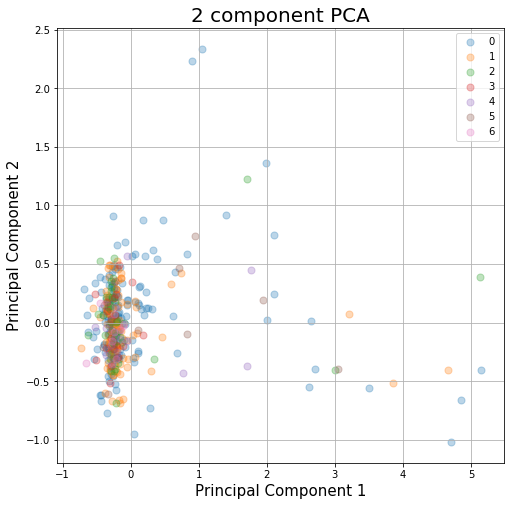

In [0]:
#PCA
##ref: https://towardsdatascience.com/pca-using-python-scikit-learn-e653f8989e60
import matplotlib.pyplot as plt
import matplotlib.cm as mplcm
import matplotlib.colors as colors
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
principalComponents = pca.fit_transform(X)
principalDf = pd.DataFrame(data = principalComponents)

finalDf = pd.concat([principalDf, pd.DataFrame(y)], axis = 1)
finalDf.columns = ['principal component 1', 'principal component 2','target']


fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)

NUM_COLORS = len(np.unique(np.array(y)))
cm = plt.get_cmap('gist_rainbow')
cNorm  = colors.Normalize(vmin=0, vmax=NUM_COLORS-1)
scalarMap = mplcm.ScalarMappable(norm=cNorm, cmap=cm)


targets = np.unique(y) 

for target in targets:
  indicesToKeep = (finalDf['target'] == target)
  ax.scatter(finalDf.loc[indicesToKeep, 'principal component 1'], finalDf.loc[indicesToKeep, 'principal component 2'], s = 50, alpha=0.3)
ax.legend(targets)
ax.grid()

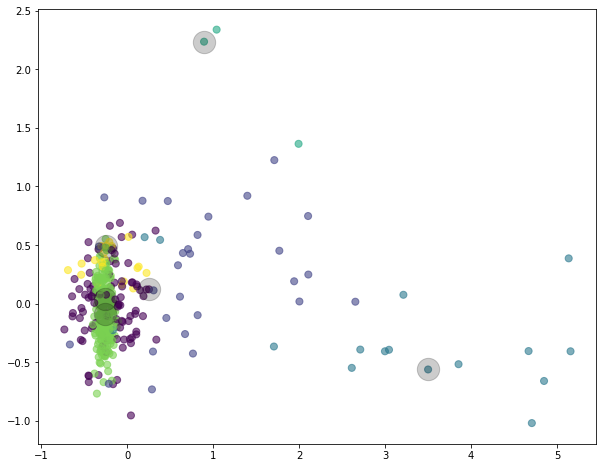

In [0]:
#GMM with EM (Note: the coloring is by gmm clustering, not by labels)
#Did this with some trials and errors. Haven't really understand conceptually how it works
#ref: https://towardsdatascience.com/gaussian-mixture-modelling-gmm-833c88587c7f

from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture
from scipy.stats import multivariate_normal as mvn

n_components=6
pose_pca = PCA(n_components = n_components) #there are 3 species

Y_sklearn = pose_pca.fit_transform(X)
gmm = GaussianMixture(n_components=n_components, covariance_type='full').fit(Y_sklearn) #EM already within this (https://scikit-learn.org/stable/auto_examples/mixture/plot_gmm.html)
prediction_gmm = gmm.predict(Y_sklearn)
probs = gmm.predict_proba(Y_sklearn)

centers = np.zeros((n_components,n_components))
for i in range(n_components):
    density = mvn(cov=gmm.covariances_[i], mean=gmm.means_[i]).logpdf(Y_sklearn)
    centers[i, :] = Y_sklearn[np.argmax(density)]

plt.figure(figsize = (10,8))
plt.scatter(Y_sklearn[:, 0], Y_sklearn[:, 1],c=prediction_gmm ,s=50, cmap='viridis', alpha=0.6)
plt.scatter(centers[:, 0], centers[:, 1],c='black', s=500, alpha=0.2);

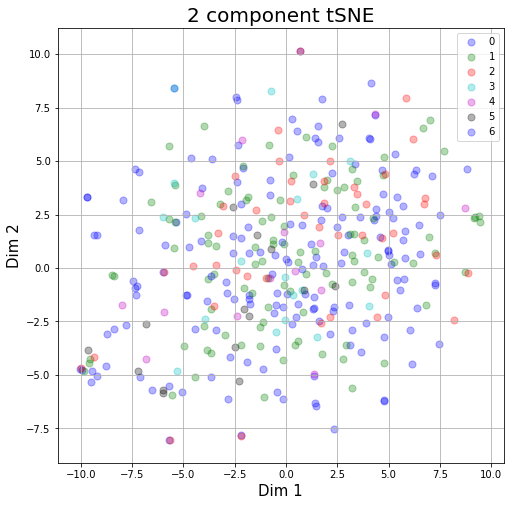

In [0]:
# t-SNE
##ref: https://medium.com/@sourajit16.02.93/tsne-t-distributed-stochastic-neighborhood-embedding-state-of-the-art-c2b4b875b7da
from sklearn.manifold import TSNE 


# Module for standardization
from sklearn.preprocessing import StandardScaler
#Get the standardized data
standardized_data = StandardScaler().fit_transform(X)

model = TSNE(n_components=2) #n_components means the lower dimension

low_dim_data = pd.DataFrame(model.fit_transform(standardized_data))


finalDf = pd.concat([low_dim_data, pd.DataFrame(y)], axis = 1)
finalDf.columns = ['Dim 1', 'Dim 2','target']


fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Dim 1', fontsize = 15)
ax.set_ylabel('Dim 2', fontsize = 15)
ax.set_title('2 component tSNE', fontsize = 20)
targets = np.unique(y)

from itertools import cycle
cycol = cycle('bgrcmk')

for target in targets:
  indicesToKeep = (finalDf['target'] == target)
  ax.scatter(finalDf.loc[indicesToKeep, 'Dim 1'], finalDf.loc[indicesToKeep, 'Dim 2'], s = 50, color=next(cycol), alpha=0.3)
ax.legend(targets)
ax.grid()

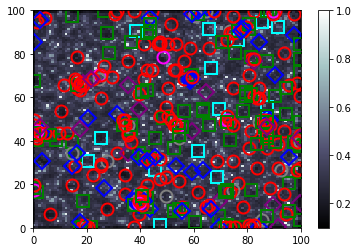

In [0]:
# self-organizing map
##ref: https://rubikscode.net/2018/08/27/implementing-self-organizing-maps-with-python-and-tensorflow/
##ref: https://pypi.org/project/MiniSom/
##ref: https://github.com/JustGlowing/minisom
##ref: https://glowingpython.blogspot.com/2013/09/self-organizing-maps.html
#!pip install minisom
from minisom import MiniSom
from numpy import genfromtxt,array,linalg,zeros,apply_along_axis

data = X
# normalization to unity of each pattern in the data
data = apply_along_axis(lambda x: x/linalg.norm(x),1,data)

from minisom import MiniSom
### Initialization and training ###
som = MiniSom(100,100,X.shape[1],sigma=1.0,learning_rate=0.5)
som.random_weights_init(data)
som.train_random(data,100) # training with 100 iterations

from pylab import plot,axis,show,pcolor,colorbar,bone
bone()
pcolor(som.distance_map().T) # distance map as background
colorbar()

# use different colors and markers for each label
markers = ['o','s','D','o','s','D','o']
colors = ['r','g','b','grey','cyan','purple','magenta']
for cnt,xx in enumerate(data):
 w = som.winner(xx) # getting the winner
 # palce a marker on the winning position for the sample xx
 plot(w[0]+.5,w[1]+.5,markers[y[cnt]],markerfacecolor='None',
   markeredgecolor=colors[y[cnt]],markersize=12,markeredgewidth=2)
show() # show the figure